In [ ]:
words = open('../names.txt', 'r').read().splitlines()
words[:2]

['emma', 'olivia']

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
chars = ['.'] + sorted(set(''.join(words)))
stoi = {k:i for i, k in enumerate(chars)}
itos = {v:k for k, v in stoi.items()}

In [ ]:

X, Y = [], []
for word in words:
    context = [0] * 3
    
    for w in word + '.':
        #print(contex, w)
        X.append(context)
        Y.append(stoi[w])
        #print(''.join(itos[i] for i in context), '--->', w)
        context = context[1:] + [stoi[w]]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
assert len(X) == len(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size
    
        for w in word + '.':
            #print(contex, w)
            X.append(context)
            Y.append(stoi[w])
            #print(''.join(itos[i] for i in context), '--->', w)
            context = context[1:] + [stoi[w]]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [ ]:
C = torch.randn((27, 2))

In [ ]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

In [ ]:
X.shape, len(X), emb.view(len(emb), -1).shape

(torch.Size([228146, 3]), 228146, torch.Size([228146, 6]))

In [ ]:
h = torch.tanh(emb.view(len(emb), -1) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [ ]:
loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(15.9562)

## Finding lr

In [ ]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
bs = 128
lr = 0.1

In [ ]:
for p in parameters:
    p.requires_grad_(True)

In [ ]:
lri = []
lossi = []

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
len(lrs)

1000

In [ ]:
for i in range(len(lrs)):
    # mini batch 
    ix = torch.randint(0, Xtr.shape[0], (bs,))

    #forward pass
    emb = C[Xtr[ix]].view((bs, -1))              # shape: bs,-1

    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None

    loss = F.cross_entropy(logits, Ytr[ix])
    
    #print(loss.item())
    
    loss.backward()

    for p in parameters:
        p.data -= lrs[i] * p.grad
    
    lossi.append(loss.log().item())
    lri.append(lrs[i])

Text(0, 0.5, 'loss')

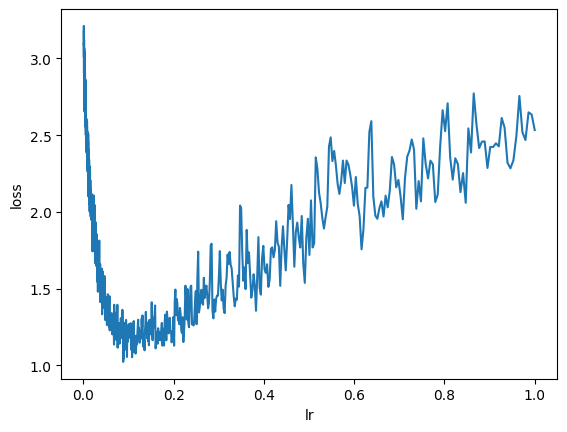

In [ ]:
plt.plot(lri, lossi)
plt.xlabel('lr')
plt.ylabel('loss')

lr = [0.1, 0.2]

## with lr = 0.1 and bs = 64

In [ ]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad_(True)

In [ ]:
bs = 64
lr = 0.1

In [ ]:
lri = []
lossi = []

In [ ]:
for i in range(200000):
    # mini batch 
    ix = torch.randint(0, Xtr.shape[0], (bs,))

    #forward pass
    emb = C[Xtr[ix]].view((bs, -1))              # shape: bs,-1

    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None

    loss = F.cross_entropy(logits, Ytr[ix])
    
    #print(loss.item())
    
    loss.backward()

    lr = lr if i < 100000 else lr/100
    for p in parameters:
        
        p.data -= lr * p.grad
            
    
    lossi.append(loss.log().item())
    lri.append(i)

In [ ]:
emb_dev = C[Xdev].view((-1, W1.shape[0]))
h_dev = torch.tanh(emb_dev @ W1 + b1)
logits_dev = h_dev @ W2 + b2
loss_dev = F.cross_entropy(logits_dev, Ydev)
print(f"train loss : {loss.item():.4f}, dev loss : {loss_dev.item():.4f}")

train loss : 2.3148, dev loss : 2.3529


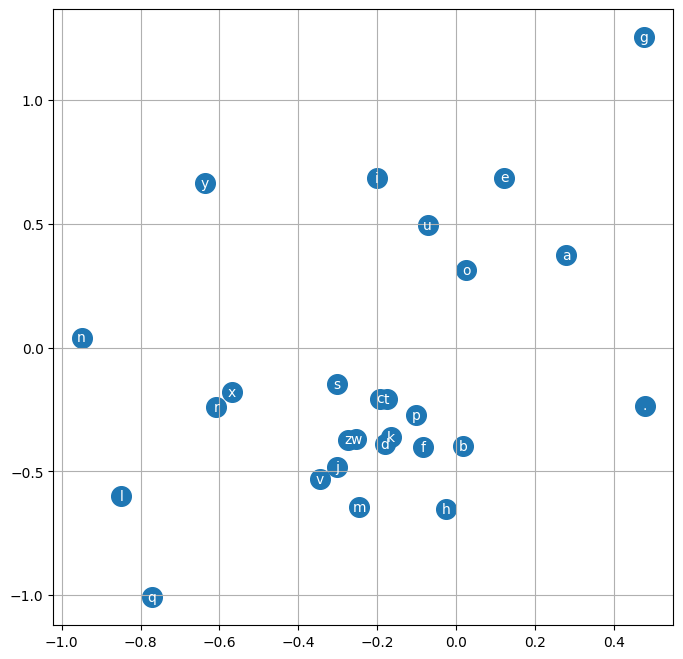

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Text(0, 0.5, 'loss')

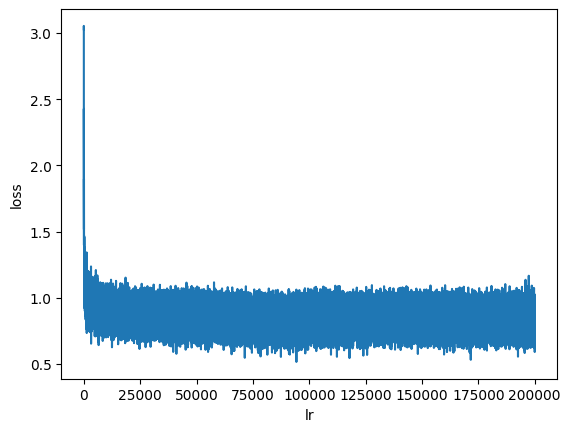

In [ ]:
plt.plot(lri, lossi)
plt.xlabel('lr')
plt.ylabel('loss')

## Tune the hyperparameters of the training to beat my best validation loss of 2.2
with lr = 0.1, bs = 256, embedding dim = 20

In [ ]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((60, 120), generator=g)
b1 = torch.randn(120, generator=g)
W2 = torch.randn((120, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad_(True)

In [ ]:
bs = 256
lr = 0.1

In [ ]:
lri = []
lossi = []

In [ ]:
for i in range(200000):
    # mini batch 
    ix = torch.randint(0, Xtr.shape[0], (bs,))

    #forward pass
    emb = C[Xtr[ix]].view((bs, -1))              # shape: bs,-1

    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None

    loss = F.cross_entropy(logits, Ytr[ix])
    
    #print(loss.item())
    
    loss.backward()

    lr = lr if i < 100000 else lr/100
    for p in parameters:
        
        p.data -= lr * p.grad
            
    
    lossi.append(loss.log().item())
    lri.append(i)

In [ ]:
emb_dev = C[Xdev].view((-1, W1.shape[0]))
h_dev = torch.tanh(emb_dev @ W1 + b1)
logits_dev = h_dev @ W2 + b2
loss_dev = F.cross_entropy(logits_dev, Ydev)
print(f"train loss : {loss.item():.4f}, dev loss : {loss_dev.item():.4f}")

train loss : 2.0861, dev loss : 2.1616


Text(0, 0.5, 'loss')

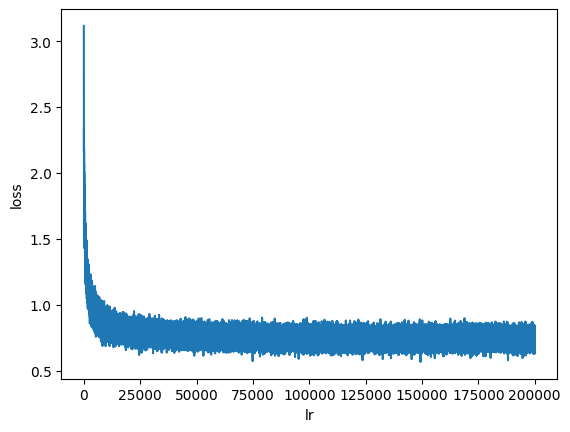

In [ ]:
plt.plot(lri, lossi)
plt.xlabel('lr')
plt.ylabel('loss')

## 1. I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [ ]:
w = torch.empty(3, 5)
print(w.shape)
w = torch.nn.init.uniform_(w)
w

torch.Size([3, 5])


tensor([[0.1170, 0.5057, 0.2301, 0.7359, 0.4985],
        [0.5969, 0.2751, 0.3282, 0.0919, 0.7979],
        [0.9263, 0.4689, 0.2544, 0.5897, 0.1130]])

In [ ]:
def gen_uni(dim, generator=g):
    w = torch.empty(dim)
    return torch.nn.init.uniform_(w)
gen_uni((3,3),g).shape

torch.Size([3, 3])

In [ ]:
g = torch.Generator().manual_seed(2147483647) 
C = gen_uni((27, 20), generator=g)
W1 = gen_uni((60, 120), generator=g)
b1 = gen_uni(120, generator=g)
W2 = gen_uni((120, 27), generator=g)
b2 = gen_uni(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad_(True)

In [ ]:
bs = 256
lr = 0.1

In [ ]:
lri = []
lossi = []

In [ ]:
for i in range(300000):
    # mini batch 
    ix = torch.randint(0, Xtr.shape[0], (bs,))

    #forward pass
    emb = C[Xtr[ix]].view((bs, -1))              # shape: bs,-1

    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2

    for p in parameters:
        p.grad = None

    loss = F.cross_entropy(logits, Ytr[ix])
    
    #print(loss.item())
    
    loss.backward()

    lr = lr if i < 150000 else lr/100
    for p in parameters:
        
        p.data -= lr * p.grad
            
    
    lossi.append(loss.log().item())
    lri.append(i)

In [ ]:
emb_dev = C[Xdev].view((-1, W1.shape[0]))
h_dev = torch.tanh(emb_dev @ W1 + b1)
logits_dev = h_dev @ W2 + b2
loss_dev = F.cross_entropy(logits_dev, Ydev)
print(f"train loss : {loss.item():.4f}, dev loss : {loss_dev.item():.4f}")

train loss : 2.9389, dev loss : 2.8481


Text(0, 0.5, 'loss')

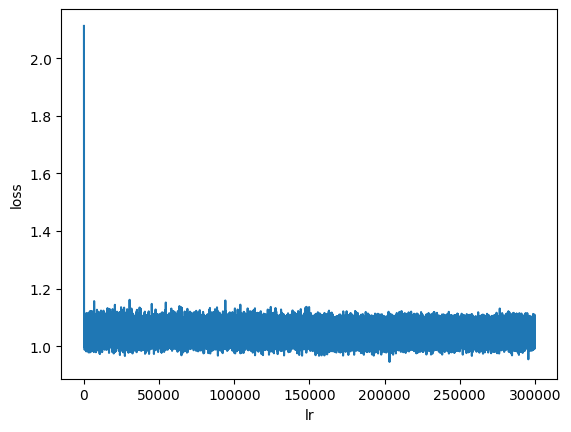

In [ ]:
plt.plot(lri, lossi)
plt.xlabel('lr')
plt.ylabel('loss')

## Exercises:
1. Tune the hyperparameters of the training to beat my best validation loss of 2.2
1. I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
1. Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?